# Step 2-1. XGBoost Baseline Modeling
----
### Objective
1. Heuristic하게 정한 임의의 파라메터로 **Sagemaker에 내장된 XGBoost 알고리즘**으로 **classification 모델을 학습**합니다.
2. 학습이 완료된 모델 파라메터를 로컬 공간으로 복사하여 검증셋 or 테스트셋에 대한 예측을 수행합니다.
    - 이 방법은 Endpoint로 배포하는 것 외에 별도로 예측을 수행하거나 모델 앙상블(Model Ensemble) 수행 시에 유용합니다.
3. Endpoint에 학습된 모델을 배포(deployment)하여 검증셋 or 테스트셋에 대한 예측을 수행합니다.
4. 기본적인 모델 Evaluation을 수행합니다. **본 결과의 수치를 Baseline**으로 하여 다음 단계들을 통해 모형 성능을 개선해 나갈 것입니다.

In [1]:
import boto3
import os
import numpy as np
import pandas as pd

s3 = boto3.client('s3')
feature_dir_name = 'modeling-feature-190808'     
bucket = 'analytics-preprocessed-daekeun'    # s3 bucket name
dataset = 'homecredit'
prefix_target = os.path.join(dataset, feature_dir_name)

In [2]:
# get_execution_role 함수는 노트북 인스턴스를 생성할 때 만든 IAM 역할 검색
from sagemaker import get_execution_role
role = get_execution_role()
region = boto3.Session().region_name
print(region)

us-west-2


In [3]:
import sagemaker
from sagemaker.predictor import csv_serializer
from sagemaker.amazon.amazon_estimator import get_image_uri

s3_trn_path = 's3://{}/{}/train.libsvm'.format(bucket, prefix_target)
s3_val_path = 's3://{}/{}/valid.libsvm'.format(bucket, prefix_target)
s3_trn_input = sagemaker.s3_input(s3_data=s3_trn_path, content_type='libsvm')
s3_val_input = sagemaker.s3_input(s3_data=s3_val_path, content_type='libsvm')

s3_out_path = 's3://{}/{}/output'.format(bucket, dataset)
print([s3_trn_path, s3_val_path, s3_out_path])

['s3://analytics-preprocessed-daekeun/homecredit/modeling-feature-190808/train.libsvm', 's3://analytics-preprocessed-daekeun/homecredit/modeling-feature-190808/valid.libsvm', 's3://analytics-preprocessed-daekeun/homecredit/output']


<br>

## 1. Model Training
----
- XGBoost(eXtreme Gradient Boosting) 알고리즘으로 학습을 수행합니다. XGBoost는 정형 데이터(tabular data)에 강점을 보이는 gradient 부스팅 트리 알고리즘입니다. 
- 각 하이퍼파라메터의 의미는 아래 링크를 참조 바랍니다.
    - https://docs.aws.amazon.com/ko_kr/sagemaker/latest/dg/xgboost_hyperparameters.html

In [4]:
sess = sagemaker.Session()

container = get_image_uri(boto3.Session().region_name, 'xgboost')
xgb_model = sagemaker.estimator.Estimator(
    container,
    role,
    train_instance_count=1,
    train_instance_type='ml.m5.4xlarge',
    output_path=s3_out_path,
    sagemaker_session=sess
)

param = {'max_depth': 6, 
         'colsample_bytree':0.7, 
         'subsample': 0.7,
         'scale_pos_weight': 8,
         'min_child_weight': 20,
         'eta': 0.025,
         'gamma': 0,
         'alpha': 0,
         'lambda': 0.05,
         'eval_metric':'auc',         
         'objective':'binary:logistic',
         'num_round': 200
        }

xgb_model.set_hyperparameters(**param)

In [5]:
%%time
xgb_model.fit({'train': s3_trn_input, 'validation': s3_val_input}) 

2019-08-16 01:49:33 Starting - Starting the training job...
2019-08-16 01:49:36 Starting - Launching requested ML instances......
2019-08-16 01:50:41 Starting - Preparing the instances for training...
2019-08-16 01:51:26 Downloading - Downloading input data
2019-08-16 01:51:26 Training - Downloading the training image..
Arguments: train
[2019-08-16:01:51:40:INFO] Running standalone xgboost training.
[2019-08-16:01:51:40:INFO] File size need to be processed in the node: 475.87mb. Available memory size in the node: 54935.61mb
[01:51:40] S3DistributionType set as FullyReplicated
[01:51:40] 244815x374 matrix with 38812316 entries loaded from /opt/ml/input/data/train
[01:51:40] S3DistributionType set as FullyReplicated
[01:51:41] 61205x374 matrix with 9706915 entries loaded from /opt/ml/input/data/validation
[01:51:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[0]#011train-auc:0.700183#011validation-auc:0.683119
[01:51:42] src/tree

[01:52:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[54]#011train-auc:0.776453#011validation-auc:0.749025
[01:52:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[55]#011train-auc:0.776927#011validation-auc:0.74936
[01:52:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[56]#011train-auc:0.777362#011validation-auc:0.74968
[01:52:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[57]#011train-auc:0.777817#011validation-auc:0.749944
[01:52:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[58]#011train-auc:0.778338#011validation-auc:0.750316
[01:52:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[59]#011train-auc:0.778386#011validation-auc:0.750425


[01:52:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[113]#011train-auc:0.796877#011validation-auc:0.761403
[01:52:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[114]#011train-auc:0.797183#011validation-auc:0.761586
[01:52:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[115]#011train-auc:0.797463#011validation-auc:0.761716
[01:52:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[116]#011train-auc:0.797724#011validation-auc:0.76187
[01:52:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[117]#011train-auc:0.797941#011validation-auc:0.761992
[01:52:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[118]#011train-auc:0.798267#011validation-auc:0.

[01:53:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[173]#011train-auc:0.812149#011validation-auc:0.769011
[01:53:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[174]#011train-auc:0.812395#011validation-auc:0.769104
[01:53:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[175]#011train-auc:0.812555#011validation-auc:0.769213
[01:53:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[176]#011train-auc:0.812831#011validation-auc:0.769363
[01:53:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[177]#011train-auc:0.813054#011validation-auc:0.769449
[01:53:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[178]#011train-auc:0.813246#011validation-auc:0.7

<br>

## 2. Model Inference in Local
----
- Checkpoint를 생성하여 deploy하기 전에 S3에 저장된 모델을 jupyter notebook이 실행되고 있는 로컬 폴더로 복사하여 prediction을 수행해 봅니다.
- 이 과정을 통해 모델의 성능을 예측할 수 있으며, endpoint로 deploy된 모델과의 비교를 수행할 수 있습니다. 본격적으로 Endpoint로 올리기 전에 빠르게 검증할 수 있는 효율적인 방법입니다.

- AUPRC(Area Under Precision Recall Curve)에 대해서는 **`step3-Evaluation.ipynb`**에서 자세히 다룹니다.

In [14]:
%%sh
export TRAINING_JOB_NAME='xgboost-2019-08-16-01-49-33-608'
export MODEL_ARTIFACT=`aws sagemaker describe-training-job \
--training-job-name $TRAINING_JOB_NAME \
--query ModelArtifacts.S3ModelArtifacts \
--output text`

echo $MODEL_ARTIFACT

aws s3 cp $MODEL_ARTIFACT .
tar xvfz model.tar.gz

s3://analytics-preprocessed-daekeun/homecredit/output/xgboost-2019-08-16-01-49-33-608/output/model.tar.gz
download: s3://analytics-preprocessed-daekeun/homecredit/output/xgboost-2019-08-16-01-49-33-608/output/model.tar.gz to ./model.tar.gz
xgboost-model


In [19]:
import xgboost as xgb
import joblib, pickle
model_local = pickle.load(open("xgboost-model", "rb"))
val_data, val_y = joblib.load('trnval/valid.pkl')
dval = xgb.DMatrix(val_data.values)

confusion matrix (cutoff=0.5)
              precision    recall  f1-score   support

           0       0.95      0.77      0.85     56263
           1       0.17      0.54      0.26      4942

   micro avg       0.76      0.76      0.76     61205
   macro avg       0.56      0.66      0.56     61205
weighted avg       0.89      0.76      0.81     61205



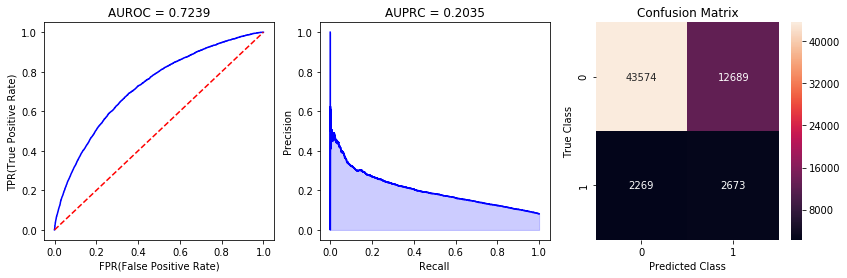

In [20]:
%matplotlib inline
val_y_pred_local = model_local.predict(dval)
from evaluate_fn import evaluate_prediction, get_score_df
evaluate_prediction(val_y.values, val_y_pred_local)

<br>

## 3. Model Deployment to SageMaker Endpoints
----
- 모델을 학습했으므로 실시간 Endpoint에 호스팅되는 모델을 배포합니다.
- 본 데모에서는 SageMaker Python SDK의 `sagemaker.predictor.RealTimePredictor` 객체를 사용하여 검증데이터에 대한 예측을 수행합니다.
- Amazon Sagemaker Python SDK을 활용하여 아래 예시처럼 간단하게 Endpoint 생성이 가능합니다.
```python
# Example
xgb_predictor = xgb_model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')
```
- 참조:
    - https://docs.aws.amazon.com/ko_kr/sagemaker/latest/dg/ex1-test-model-endpoint.html
    - https://sagemaker.readthedocs.io/en/stable/predictors.html#sagemaker.predictor.RealTimePredictor

In [10]:
%%time
xgb_predictor = xgb_model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

--------------------------------------------------------------------------------------------------------------------!CPU times: user 494 ms, sys: 82.8 ms, total: 577 ms
Wall time: 9min 45s


- Loop over our test dataset
- Split it into mini-batches of rows
- Convert those mini-batches to CSV string payloads (notice, we drop the target variable from our dataset first)
- Retrieve mini-batch predictions by invoking the XGBoost endpoint
- Collect predictions and convert from the CSV output our model provides into a NumPy array

In [12]:
%%time
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

from evaluate_fn import predict_from_realtime_predictor
val_y_pred_endpoint = predict_from_realtime_predictor(val_data.values, xgb_predictor)

CPU times: user 30.9 s, sys: 546 ms, total: 31.4 s
Wall time: 2min 28s


confusion matrix (cutoff=0.5)
              precision    recall  f1-score   support

           0       0.95      0.77      0.85     56263
           1       0.17      0.54      0.26      4942

   micro avg       0.76      0.76      0.76     61205
   macro avg       0.56      0.66      0.56     61205
weighted avg       0.89      0.76      0.81     61205



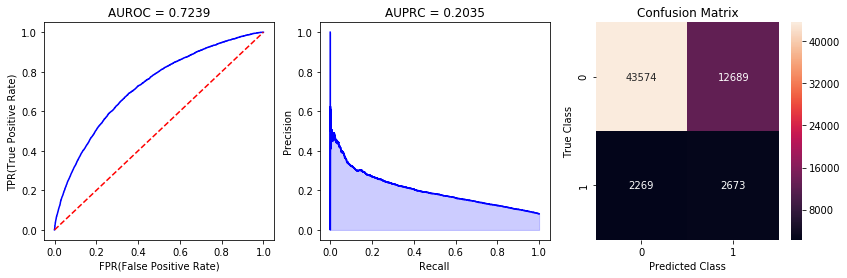

In [21]:
evaluate_prediction(val_y.values, val_y_pred_endpoint)

In [17]:
# delete endpoint
xgb_predictor.delete_endpoint()